In [5]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Average plane Z positions
Z_DC31_X = -(10.3+7.3-1.7-4.7)/4.0
Z_DC31_Y = -(4.3+1.3-7.7-10.7)/4.0
Z_DC32_X = -(4.5+1.5)/2.0
Z_DC32_Y = -(-1.5-4.5)/2.0

# Detector Z positions
Z_DC31 = -271.5 # mm
Z_DC32 = 787.97 # mm
Z_SRPPAC = 0.0 # mm

spark = SparkSession.builder.master("local[10]").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

df = spark.read.parquet("parquet/run1082_joined.parquet")
df.show(5)

+---------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+
|hbfNumber|           sr_pos_x|           sr_pos_y|            dc31_x|             dc31_y|             dc32_x|             dc32_y|
+---------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+
|  4859428|-11.352156579494476|-11.815886080265045|10.258760452270508| -5.232571125030518| 12.627519607543945|-2.6095685958862305|
|  4847090|  9.077205091714859|  4.448190271854401|-9.300735473632812|  8.381937026977539|  -9.53784465789795| 11.536351203918457|
|  4877987| -10.95768940448761| 15.097443521022797|   9.9695463180542| 18.030445098876953| 12.246641159057617| 23.100234985351562|
|  4878942|  6.004988670349121| -5.537410080432892|-8.849443435668945|-1.8167548179626465| -10.91977310180664| 0.6183762550354004|
|  4846974|  5.441210508346558|-12.197594463825226|-8.343795776367188| -4.913448810

In [6]:
L2X = Z_DC32 - Z_SRPPAC + Z_DC32_X
L2Y = Z_DC32 - Z_SRPPAC + Z_DC32_Y
L1X = Z_DC31 - Z_SRPPAC + Z_DC31_X
L1Y = Z_DC31 - Z_SRPPAC + Z_DC31_Y

df_chk = df.withColumn("interp_mwdc_x", F.expr(f"-(dc31_x * {L2X} - dc32_x * {L1X})/(ABS({L1X}) + ABS({L2X}))")) \
           .withColumn("interp_mwdc_y", F.expr(f"(dc31_y * {L2Y} - dc32_y * {L1Y})/(ABS({L1Y}) + ABS({L2Y}))"))
df_chk.show(5)

+---------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|hbfNumber|           sr_pos_x|           sr_pos_y|            dc31_x|             dc31_y|             dc32_x|             dc32_y|      interp_mwdc_x|      interp_mwdc_y|
+---------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|  4859428|-11.352156579494476|-11.815886080265045|10.258760452270508| -5.232571125030518| 12.627519607543945|-2.6095685958862305|-10.872155182878855| -4.568197000804011|
|  4847090|  9.077205091714859|  4.448190271854401|-9.300735473632812|  8.381937026977539|  -9.53784465789795| 11.536351203918457|   9.36213535208111|  9.180911154134211|
|  4877987| -10.95768940448761| 15.097443521022797|   9.9695463180542| 18.030445098876953| 12.246641159057617| 23.100234985351562|-10.55920439851

Statistics:
[[0.000e+00 0.000e+00 0.000e+00]
 [1.000e+00 4.285e+03 0.000e+00]
 [0.000e+00 5.000e+00 0.000e+00]]


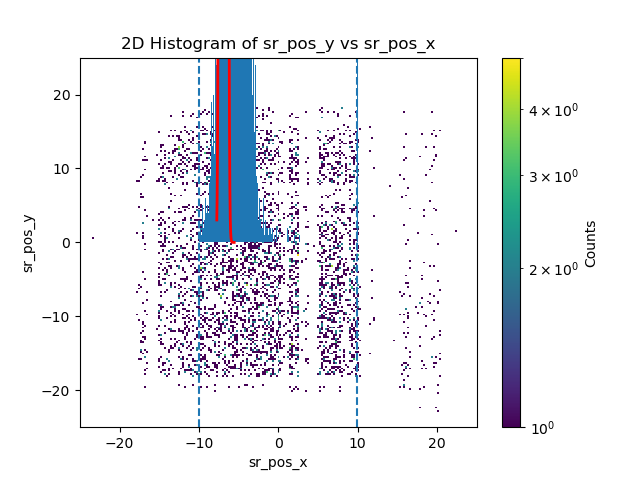

Statistics:
[[0.000e+00 0.000e+00 0.000e+00]
 [1.000e+00 4.305e+03 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00]]


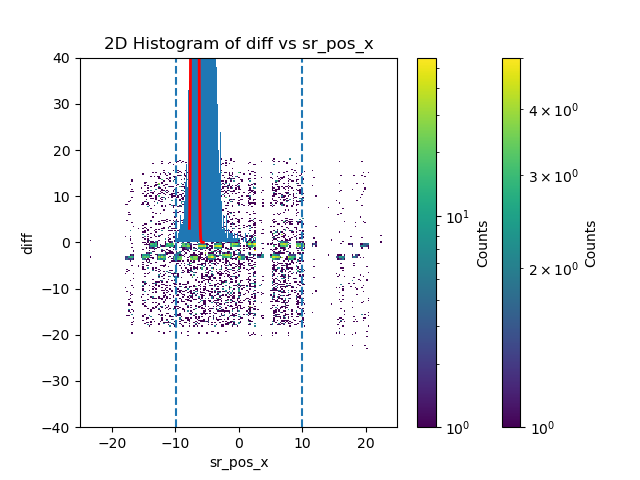

Statistics:
[[0.000e+00 0.000e+00 0.000e+00]
 [4.000e+00 4.286e+03 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00]]


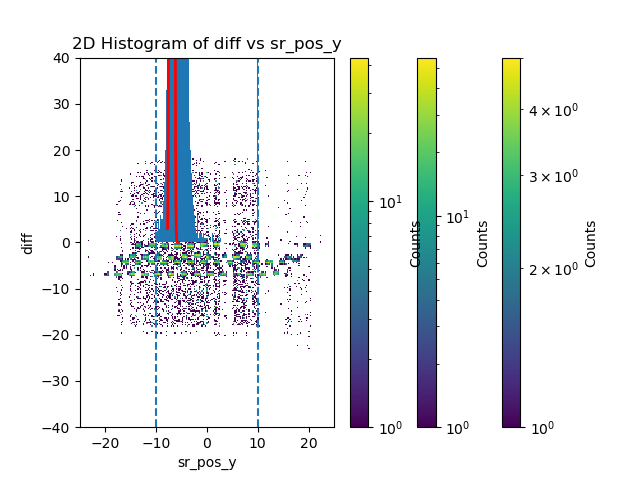

Total entries: 4306, Underflow: 0, Inside: 4306, Overflow: 0


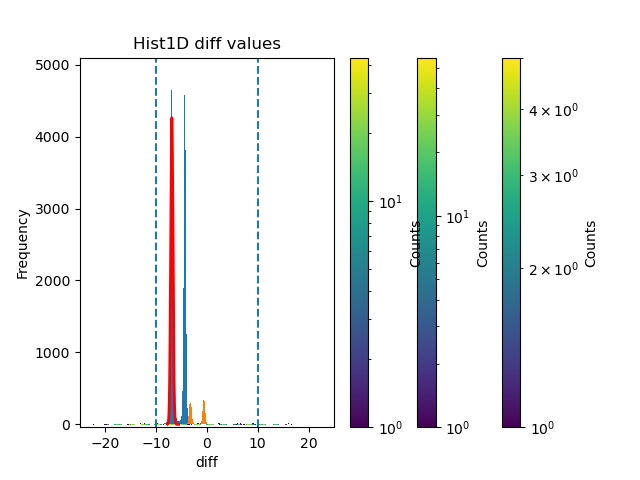

Total entries: 4291, Underflow: 1, Inside: 4290, Overflow: 0


In [7]:
from hist.sparkHist2d import Hist2D
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

h = Hist2D(df_chk, ["sr_pos_x", "sr_pos_y"], [200,200], [[-25,25], [-25,25]], norm=LogNorm(), interpolation='none')
plt.show()
h = Hist2D(df_chk.withColumn("diff", F.expr("sr_pos_x - interp_mwdc_x")), ["sr_pos_x", "diff"], [200,200], [[-25,25], [-40,40]], norm=LogNorm(), interpolation='none')
plt.show()
h = Hist2D(df_chk.withColumn("diff", F.expr("sr_pos_y - interp_mwdc_y")), ["sr_pos_y", "diff"], [200,200], [[-25,25], [-40,40]], norm=LogNorm(), interpolation='none')
plt.show()
from hist.sparkHist1d import Hist1D
h = Hist1D(df_chk.withColumn("diff", F.expr("sr_pos_x - interp_mwdc_x")), "diff", 200, [-10,10])
plt.show()
h = Hist1D(df_chk.withColumn("diff", F.expr("sr_pos_y - interp_mwdc_y")), "diff", 200, [-10,10])

Total entries: 4291, Underflow: 1, Inside: 4290, Overflow: 0


Output()

Output()

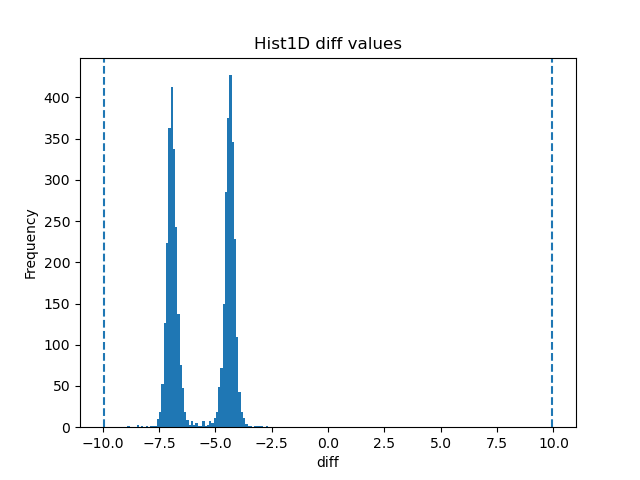

In [ ]:
%matplotlib widget

plt.clf()

from hist.sparkHist1d import Hist1D
Hist1D(df_chk.withColumn("diff", F.expr("sr_pos_y - interp_mwdc_y")), "diff", 200, [-10,10])

from matplotlib import pyplot as plt
from hist.fitHist1d import FitHist1DGauss
FitHist1DGauss()
plt.show()

